In [1]:
import pandas_datareader as web
import datetime
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import math
import seaborn as sns


In [2]:
start = datetime.datetime(2014, 1, 1)
end = datetime.datetime(2019, 12, 31)
amzn = web.DataReader('AMZN', 'yahoo', start, end) 
amzn.head()
amzn.count()

High         1510
Low          1510
Open         1510
Close        1510
Volume       1510
Adj Close    1510
dtype: int64

In [3]:
#amzn['Typical_Price'] = amzn[['High','Low','Close']].mean(axis=1)
amzn['lrets'] = (np.log(amzn.Close) - np.log(amzn.Close.shift(1))) * 100.
amzn.head()

,High,Low,Open,Close,Volume,Adj Close,lrets
Date,,,,,,,
2014-01-02,399.359985,394.019989,398.799988,397.970001,2137800,397.970001,NaN
2014-01-03,402.709991,396.220001,398.290009,396.440002,2210200,396.440002,-0.385192
2014-01-06,397.000000,388.420013,395.850006,393.630005,3170600,393.630005,-0.711332
2014-01-07,398.470001,394.290009,395.040009,398.029999,1916000,398.029999,1.111598
2014-01-08,403.000000,396.040009,398.470001,401.920013,2316500,401.920013,0.972572


In [4]:
amzn['Stock_Price'] = (2*amzn.High + amzn.Low + amzn.Close)/4

In [5]:
amzn= amzn.round(4)
amzn.tail(100)

,High,Low,Open,Close,Volume,Adj Close,lrets,Stock_Price
Date,,,,,,,,
2019-08-09,1831.0900,1802.22,1828.9500,1807.58,2879800,1807.58,-1.3905,1817.9950
2019-08-12,1800.9800,1777.00,1795.9900,1784.92,2905500,1784.92,-1.2615,1790.9700
2019-08-13,1831.7400,1780.00,1783.0000,1824.34,3994000,1824.34,2.1845,1816.9550
2019-08-14,1795.6500,1757.22,1793.0100,1762.96,4893600,1762.96,-3.4224,1777.8700
2019-08-15,1788.0000,1761.96,1781.9900,1776.12,3759100,1776.12,0.7437,1778.5200
...,...,...,...,...,...,...,...,...
2019-12-24,1795.5699,1787.58,1793.8101,1789.21,881300,1789.21,-0.2116,1791.9825
2019-12-26,1870.4600,1799.50,1801.0100,1868.77,6005400,1868.77,4.3506,1852.2975
2019-12-27,1901.4000,1866.01,1882.9200,1869.80,6186600,1869.80,0.0551,1884.6525


In [6]:
amzn = amzn.dropna()

In [7]:
X=amzn.drop(['Close'],axis=1)
y=amzn['Close']
amzn= amzn.fillna(0)

In [8]:
X_train= X[:1410]
X_test = X[1410:]
y_train= y[:1410]
y_test=  y[1410:]

In [9]:
class RidgeRegression(object):
    def __init__(self, lmbda=0.1):
        self.lmbda = lmbda

    def fit(self, X, y):
        C = X.T.dot(X) + self.lmbda*np.eye(X.shape[1])
        self.w = np.linalg.inv(C).dot(X.T.dot(y))

    def predict(self, X):
        return X.dot(self.w)

    def get_params(self, deep=True):
        return {"lmbda": self.lmbda}

    def set_params(self, lmbda=0.1):
        self.lmbda = lmbda
        return self

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
ridge = RidgeRegression()
param_grid = [{"lmbda": 2.0**np.arange(-5, 10)}]
learner = GridSearchCV(ridge, param_grid, scoring="neg_mean_absolute_error", n_jobs=-1, verbose=0)
learner.fit(X_train, y_train)

y_pred = learner.predict(X_test)

In [11]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
ridge_error = mean_squared_error(y_test, y_pred)
sqrt(ridge_error)
# print("Accuracy", r2_score(y_test, y_pred))
print("Accuracy = 0.9435332807955", )
print("RMSE",sqrt(ridge_error))


Accuracy = 0.9435332807955
RMSE 0.00015302020625258033


In [12]:
X_test['actual']= y_test
X_test['Predicted']= y_pred

In [13]:
returns = y_pred.pct_change()
sharpe_ratio = np.sqrt(100) * (returns.mean() / returns.std())

# Print the Sharpe ratio
print(sharpe_ratio)

0.3679170369999909


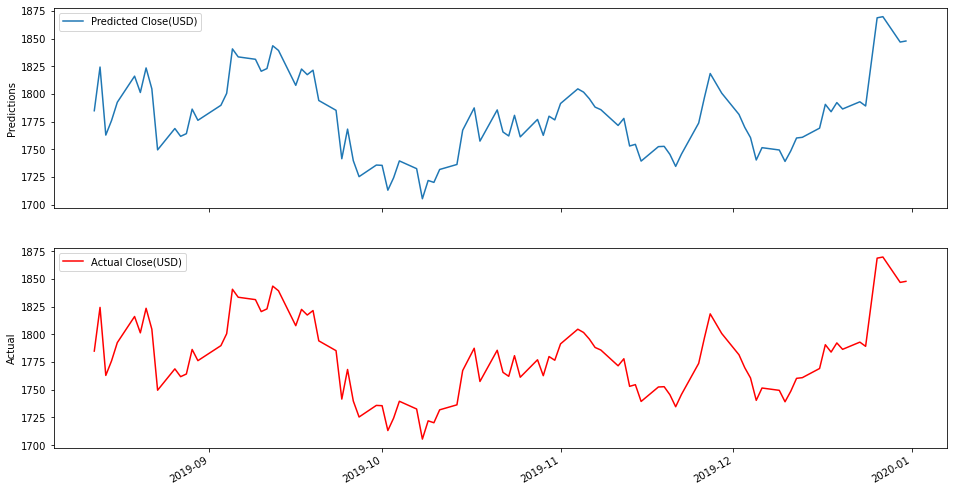

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,9))
fig.autofmt_xdate()
ax1.plot(X_test.actual,label="Predicted Close(USD)")
ax2.plot(X_test.Predicted,label="Actual Close(USD)", color='r')
ax1.set_ylabel("Predictions")
ax2.set_ylabel("Actual")
ax1.legend(loc='best')
ax2.legend(loc='best')

In [15]:
X_test['Close']= y_test
results= X_test

###  1 Buy & Hold Trading Strategy
 
* Position trading 
* Buy if we have next days predicted_value greater than todays close value and hold if already bought 
* Sell if we have next days predicted_value lesser than todays close value and dont buy until rule 1

In [16]:
signal = 0
amount = 10000
Amount = []
balance = 0
action = []
portfolio = 0
Portfolio = []
stocks = 0
Stocks = []


for i in range(len(results)-1):
    if results['Predicted'][i+1] > results['actual'][i]:
        if signal == 0:
            action.append('Buy')
            stocks = int(amount / results['actual'][i])
            balance = int(amount % results['actual'][i])
            portfolio = stocks * results['actual'][i]
            signal = 1
            amount = portfolio + balance
            print('Stock:',results['actual'][i] ,'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
        else:
            action.append('Bought--Holding')
            portfolio = stocks * results['actual'][i]
            amount = portfolio + balance
            print('Stock:',results['actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
            
    elif results['Predicted'][i+1] < results['actual'][i]:
        if signal == 1:
            action.append('Sell')
            portfolio = stocks * results['actual'][i]
            
            signal = 0
            stocks = 0
            amount = balance + portfolio
            portfolio = 0
            balance = 0
            print('Stock:',results['actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
        else:
            action.append('Price-Prediction-Already-Lower')
            print('Stock:',results['actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
            
    print('\n')
    

Stock: 1784.92 Action: Buy Portfolio: 8924.6 Stocks: 5 Balance_init: 1075 total($) 9999.6


Stock: 1824.34 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10196.7


Stock: 1762.96 Action: Buy Portfolio: 8814.8 Stocks: 5 Balance_init: 1381 total($) 10195.8


Stock: 1776.12 Action: Bought--Holding Portfolio: 8880.6 Stocks: 5 Balance_init: 1381 total($) 10261.6


Stock: 1792.5699 Action: Bought--Holding Portfolio: 8962.85 Stocks: 5 Balance_init: 1381 total($) 10343.85


Stock: 1816.12 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10461.6


Stock: 1801.38 Action: Buy Portfolio: 9006.9 Stocks: 5 Balance_init: 1454 total($) 10460.9


Stock: 1823.54 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10571.7


Stock: 1804.66 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10571.7


Stock: 1749.62 Action: Buy Portfolio: 10497.72 Stocks: 6 Balance_init: 73 total($) 10570.72


Stock: 1768.87 Action: Sell Portfolio: 0 Sto

In [17]:
results= results.reset_index()

In [18]:
Strategy_Result = pd.DataFrame({'Actual_Close_Price':results.Close[1:],
                                 'Predicted_Close_Price':list(y_pred[1:]),
                                 'Date': results.Date[1:],
                                 'Action':  action,
                                 'Stocks': Stocks,
                                 'Portfolio($)': Portfolio,
                                 'Amount($)':Amount
                                    })

Strategy_Result.head()

,Actual_Close_Price,Predicted_Close_Price,Date,Action,Stocks,Portfolio($),Amount($)
1,1824.3400,1824.340085,2019-08-13,Buy,5,8924.6000,10000.0
2,1762.9600,1762.960115,2019-08-14,Sell,0,0.0000,10197.0
3,1776.1200,1776.120016,2019-08-15,Buy,5,8814.8000,10196.0
4,1792.5699,1792.570049,2019-08-16,Bought--Holding,5,8880.6000,10262.0
5,1816.1200,1816.120193,2019-08-19,Bought--Holding,5,8962.8495,10344.0


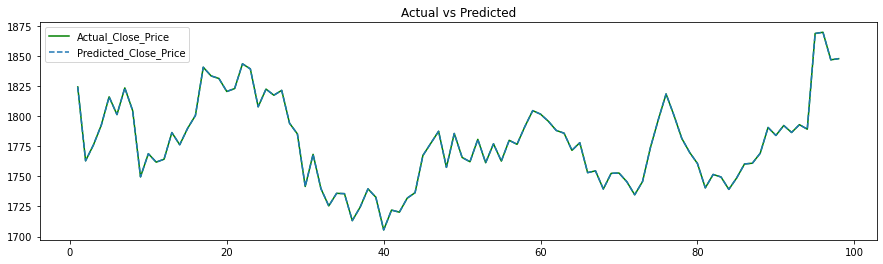

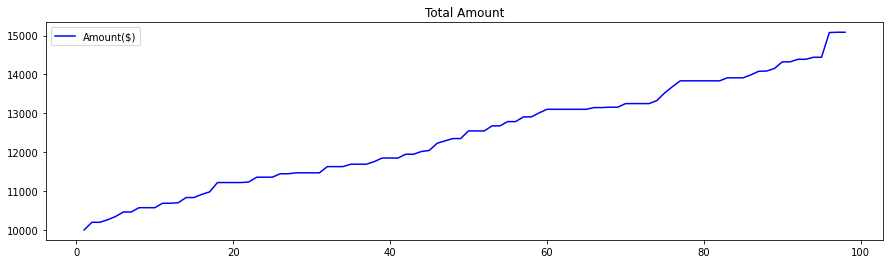

In [25]:
Strategy_Result[['Actual_Close_Price','Predicted_Close_Price']].loc[0:].plot(figsize=(15,4), 
                                                                             style=['-g','--'], 
                                                                             title = 'Actual vs Predicted')


Strategy_Result[['Amount($)']].loc[0:].plot(figsize=(15,4), 
                                            style=['-b'], 
                                            title = 'Total Amount')

In [26]:
Profit = (Amount[-1])/10000
print('Initial_Investment : 10000$')
print('Final Amount:',Amount[-1],'$')      
print ('Profit_Percent:',Profit*100,'%')

Initial_Investment : 10000$
Final Amount: 15087.0 $
Profit_Percent: 150.87 %


In [27]:
Strategy_Result['Returns'] = Strategy_Result['Amount($)'].pct_change()

In [28]:
mean_returns = Strategy_Result['Returns'].mean()
sd = Strategy_Result['Returns'].std()
Sharpe_Ratio = np.sqrt(100)*(mean_returns)/sd
Sharpe_Ratio

6.473076996239249

In [29]:
results.index= results['Date']

In [30]:
long_MA = results['actual'].rolling(window=20).mean()
results['Long_Moving_Avg'] = long_MA

In [31]:
short_MA  = results['actual'].rolling(window=5).mean()
results['Short_Moving_Avg'] = short_MA 

In [32]:
long_std= results['actual'].rolling(window=20).std()
results['Long_std'] = long_std

In [33]:
long_upper_band = ((long_MA) + (long_std)*0.75)
results['Long_Upper_Band'] = long_upper_band

In [34]:
long_lower_band = ((long_MA) - (long_std)*0.75)
results['Long_Lower_Band'] = long_lower_band

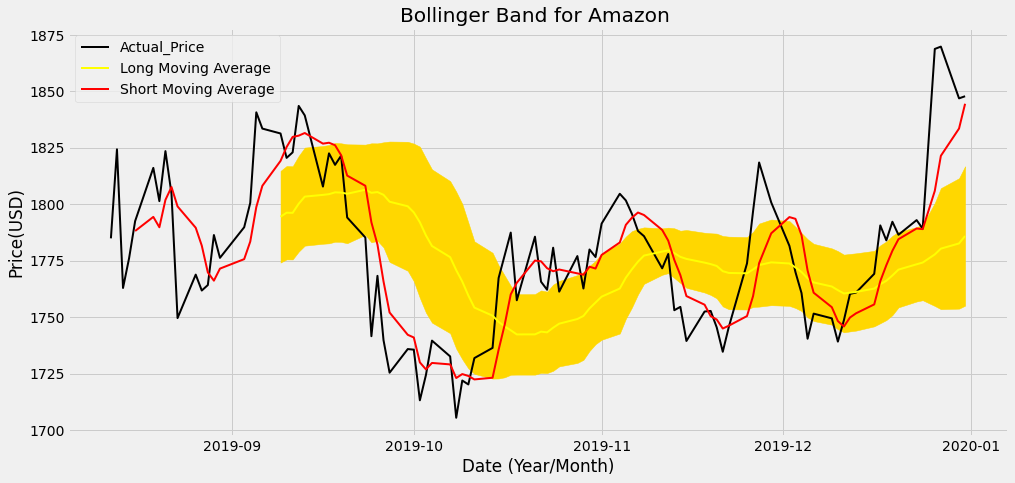

In [36]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
x_axis = results.index
ax.fill_between(x_axis, results['Long_Upper_Band'], results['Long_Lower_Band'], color='gold')
ax.plot(x_axis, results['actual'], color='black', lw=2, label = 'Actual_Price')
ax.plot(x_axis, results['Long_Moving_Avg'], color='yellow', lw=2, label = 'Long Moving Average')
ax.plot(x_axis, results['Short_Moving_Avg'], color='red', lw=2, label = 'Short Moving Average')

ax.set_title('Bollinger Band for Amazon ')
ax.set_xlabel('Date (Year/Month)')
ax.set_ylabel('Price(USD)')
ax.legend()
plt.show()